# Introduction

In this notebook, I'm trying to provide some preliminary understanding of the HappyDB dataset.  

I'll use **[Koko](./koko_intro.txt)**, an entity extraction language, to explore what products are mostly mentioned in the dataset.  

Also, I'll introduce how to develop a classifier predicting the genders of happy moments' authors, using **[scikit-learn](http://scikit-learn.org/stable/)**'s logistic regression model.  

Let's get started!

We first need to import a few necessary packages:

In [1]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, ImageColorGenerator

# 1. Data preprocessing

HappyDB consists of statement of happy moments by people around the world.  

We can load the data and take a quick look inside.

## 1.1 Load HappyDB

In [2]:
hm_data = pd.read_csv('./cleaned_hm.csv')
hm_data.head()

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,category,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,affection,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,affection,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,exercise,1,NaN,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,bonding,2,bonding,bonding
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,affection,1,NaN,affection


The dataset is composed of happy moments from two reflection_period, 24 hours and 3 months.  

Let's take a quick look at the data with reflection_period of 3 months.

In [3]:
hm_data.loc[hm_data["reflection_period"]=='3m'].head()

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,category,num_sentence,ground_truth_category,predicted_category
30455,58297,888,3m,nowing im going to travel to china soon,nowing im going to travel to china soon,True,leisure,1,leisure,leisure
30456,58298,129,3m,I ate a really good dinner.,I ate a really good dinner.,True,enjoy_the_moment,1,NaN,enjoy_the_moment
30457,58299,1354,3m,I went to a Lehigh Valley phantoms hockey game.,I went to a Lehigh Valley phantoms hockey game.,True,leisure,1,NaN,leisure
30458,58300,384,3m,I saw the woman I love.,I saw the woman I love.,True,affection,1,NaN,affection
30459,58301,1111,3m,the babyset i ordered finally came and i set i...,the baby set i ordered finally came and i set ...,False,achievement,1,NaN,achievement


Of all the columns, "cleaned_hm" is of particular interest as it contains happy moments with proper cleaning (e.g., typo correction).  

The rest of the analysis will be mostly based on "cleaned_hm".

## 1.2 Word count

To get a general idea of the cleaned happy moments, we can perform a statistical analysis based on the number of words.

In [4]:
df_hm = hm_data[hm_data['cleaned_hm'].notnull()]
len_count = df_hm['cleaned_hm'].apply(lambda x: len(x.split()))
len_count.describe()

count    100535.000000
mean         18.298503
std          21.474146
min           2.000000
25%           9.000000
50%          14.000000
75%          21.000000
max        1179.000000
Name: cleaned_hm, dtype: float64

Looks like most of the happy moments are short sentences, as expected!

Some happy moments even have only two words.

In [5]:
df_hm[df_hm['cleaned_hm'].apply(lambda x: len(x.split()))==2].head()

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,category,num_sentence,ground_truth_category,predicted_category
1100,28775,634,24h,Shooting guns.,Shooting guns.,True,leisure,1,NaN,leisure
4903,32612,7012,24h,My kids.,My kids.,True,affection,1,NaN,affection
7646,35375,2082,24h,"dude, weed","dude, weed",True,achievement,1,NaN,enjoy_the_moment
12496,40246,755,24h,watching ncis.,watching ncis.,True,leisure,1,NaN,leisure
14868,42633,10831,24h,Donated blood.,Donated blood.,True,achievement,1,NaN,achievement


So what's the distribution of the word count?

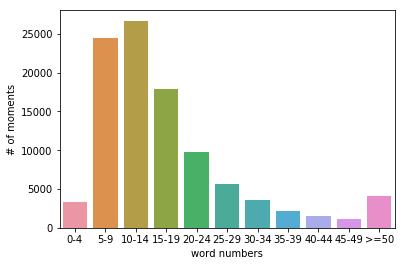

In [6]:
length_order = ["0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39", \
                "40-44", "45-49", ">=50"]
length_category = len_count.apply(lambda x: length_order[min(10, int(x/5))])
length_counts = pd.DataFrame(length_category.value_counts()).reset_index()
length_counts.columns = ['word numbers', '# of moments']

sns.barplot(x='word numbers', y='# of moments', data=length_counts, order=length_order)

Most of the happy moments are between five words and twenty words.

## 1.3 Word frequency

I'm also curious about what words people mention most in their happy moments.  

A good tool that could help us in this case is a word cloud.

(-0.5, 3599.5, 2699.5, -0.5)

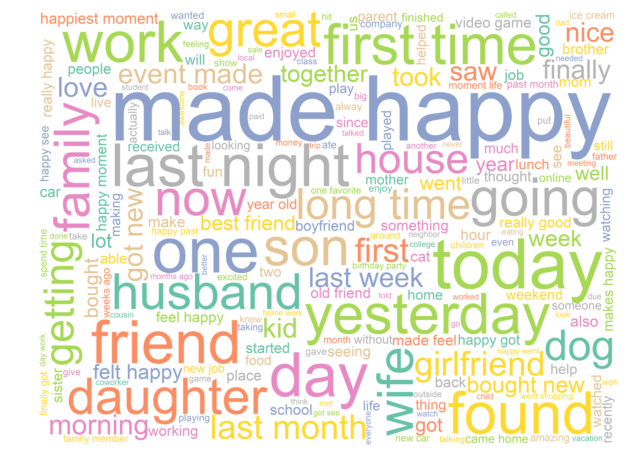

In [7]:
text = ' '.join(df_hm['cleaned_hm'].tolist())
text = text.lower()
wordcloud = WordCloud(background_color="white", font_path='../../../Library/Fonts/Arial.ttf', \
                          height=2700, width=3600).generate(text)
plt.figure( figsize=(14,8) )
plt.imshow(wordcloud.recolor(colormap=plt.get_cmap('Set2')), interpolation='bilinear')
plt.axis("off")

It seems that some words appear more frequently, such as "friend", "family" and "husband".  

There are also noise words that are not very informative, such as "happy", "yesterday" and "today".  

Let's clean the word cloud by removing these noise.

(-0.5, 3599.5, 2699.5, -0.5)

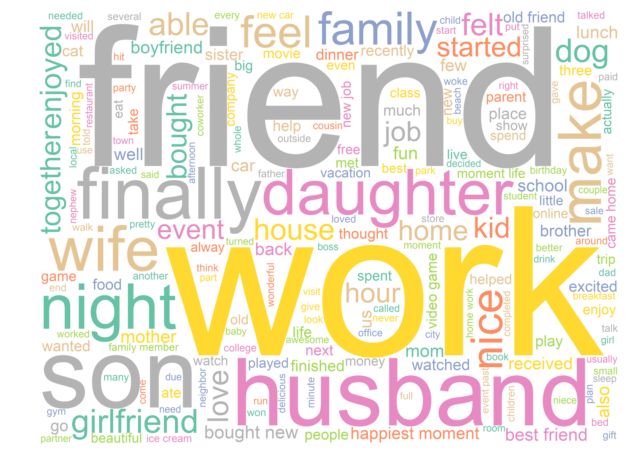

In [8]:
LIMIT_WORDS = ['happy', 'day', 'got', 'went', 'today', 'made', 'one', 'two', 'time', 'last', 'first', 'going', \
               'getting', 'took', 'found', 'lot', 'really', 'saw', 'see', 'month', 'week', 'day', \
               'yesterday', 'year', 'ago', 'now', 'still', 'since', 'something', 'great', 'good', 'long', 'thing', \
               'toi', 'without', 'yesteri', '2s', 'toand', 'ing' ]

text = ' '.join(df_hm['cleaned_hm'].tolist())
text = text.lower()
for w in LIMIT_WORDS:
    text = text.replace(' ' + w, '')
    text = text.replace(w + ' ', '')
wordcloud = WordCloud(background_color="white", font_path='../../../Library/Fonts/Arial.ttf', \
                          height=2700, width=3600).generate(text)
plt.figure( figsize=(14,8) )
plt.imshow(wordcloud.recolor(colormap=plt.get_cmap('Set2')), interpolation='bilinear')
plt.axis("off")

Great. Now it's quite clear that "work", "friend" and "son" are the most frequent words in the dataset.

# 2. Entity Extraction on HappyDB

Now let's try to dig deeper into the dataset by focusing on sub-domains of daily life.  

For example, what seasons make people happiest? What purchased products make people happiest?  

## 2.1 Happiest seasons

In [9]:
seasons = ['Spring', 'Summer', 'Fall', 'Winter']

# Check each moment, and increase the count for the mentioned season
season_dic = dict((x,0) for x in seasons)
tokens_hm = df_hm['cleaned_hm'].apply(lambda x: x.split())
for _, value in tokens_hm.iteritems():
    for word in value:
        if word in seasons:
            season_dic[word] += 1
            
season_dic

{'Fall': 6, 'Spring': 81, 'Summer': 27, 'Winter': 6}

'Spring' is clearly the winner, as it's mentioned significantly more frequently than other seasons.

I also tried to search for 'Autumns', but there's zero mentioning. Any interested reader could try yourself as well.

## 2.2 Products that make people happy

It's interesting to understand what products that people buy make them happy.

We can model the task as an entity extraction problem.  

And I'll use an entity extraction system called [Koko](./koko_intro.txt) for this task.

### 2.2.1 Generate plain-text happy moments

Koko takes texts as input. Let's first generate plain-text happy moments for query evaluation.

In [10]:
# Read the happyDB sample file
with open('./happydb.txt', 'w') as ofile:
    for i in range(0, df_hm.shape[0] - 1):
        ofile.write(df_hm['cleaned_hm'].iloc[i] + '\n')
        
print("Plain-text happy moments are generated!")

Plain-text happy moments are generated!


### 2.2.2 Extraction of purchased products

Now let's write a Koko query for product extraction as follows:

In [11]:
with open('purchase_v1.koko', 'r') as file:
    print(file.read())

extract "NPs" x from "./happydb.txt" if
	("buy" x {0.1}) or
	("purchase" x {0.1})	
with threshold 0.3



This query tells Koko to extract noun phrases 'x' from HappyDB if "x" is preceded by either "buy" or "purchase".  

The number in each "if" condition represents the weight to be added for each matching instance.  

Eventually we want entities that score higher than 0.3.

Let's run the Koko query now to see the results. I use [spaCy](https://spacy.io/) as the document parser.

In [12]:
import koko
import spacy

koko.run('./purchase_v1.koko', doc_parser='spacy')

Parsed query: extract "./happydb.txt" NPs from "x" if
	("buy" x { 0.10 }) or
	("purchase" x { 0.10 })   
with threshold 0.30


Results:

Entity name                    Entity count         Entity score
something                      17                   1.000000
a car                          15                   1.000000
a new car                      21                   1.000000
me                             10                   1.000000
it                             37                   1.000000
them                           10                   1.000000
costumes                       25                   1.000000
tickets                        9                    0.900000
myself                         9                    0.900000
a new phone                    8                    0.800000
groceries                      8                    0.800000
a house                        7                    0.700000
a home                         7                    0.700000
thing

On one hand, the results give us useful information.  
People are in general happy when they purchase a car, followed by costumes, tickets and phones etc.

On the other hand, there's much noise in the results.  We have pronouns such as "me", "he" and "my son" as well.  
This's not surprising though, as we often "buy sb. sth." in daily life.

**Fortunately, Koko allows us to specify exclusion rules to get rid of the unwanted noise.**

Here's an updated query excluding pronouns:

In [13]:
with open('purchase_v2.koko', 'r') as file:
    print(file.read())

extract "NPs" x from "./happydb.txt" if
	("buy" x {0.1}) or
	("purchase" x {0.1})	
with threshold 0.3

excluding(str(x) matches "(I|i|me|we|us|he|him|she|her|they|them|it)")
excluding(str(x) matches "(my|our|his|her|their).*")


Let's run it again.

In [14]:
koko.run('./purchase_v2.koko', doc_parser='spacy')

Parsed query: extract "./happydb.txt" NPs from "x" if
	("buy" x { 0.10 }) or
	("purchase" x { 0.10 })   
with threshold 0.30
excluding
	(str(x) matches "(I|i|me|we|us|he|him|she|her|they|them|it)")
	(str(x) matches "(my|our|his|her|their).*")


Results:

Entity name                    Entity count         Entity score
something                      17                   1.000000
a car                          15                   1.000000
a new car                      21                   1.000000
costumes                       25                   1.000000
tickets                        9                    0.900000
a new phone                    8                    0.800000
groceries                      8                    0.800000
a house                        7                    0.700000
a home                         7                    0.700000
things                         6                    0.600000
food                           6                    0.600000
a Nintend

The results look much cleaner this time.

If we take a closer look at the query, we might wonder if the two conditions listed cover all the purchasing behavior?  
The answer may be no.

In [15]:
# Select all the happy moments that contain 'purchased'.
df_purchase = df_hm[df_hm['cleaned_hm'].apply(lambda x: x.find('purchased') != -1)]

print("Number of happy moments containing 'purchased': {}".format(df_purchase.shape[0]))

598

Wow, looks like we missed quite a few happy moments that contain 'purchased'.

However, enumerating all purhcase-related keywords we can think of in a Koko query is quite tedious.  

Koko provides a handy feature for solving this problem, which is called descriptor.  
To use a descriptor, we only need to write *one* condition, and put a tilde "~" between the keyword in the condition and the entity we're trying to extract.  

In [16]:
with open('purchase_v3.koko', 'r') as file:
    print(file.read())

extract "NPs" x from "./happydb.txt" if
	("purchase" ~ x {0.1})
with threshold 0.3

excluding(str(x) matches "(I|i|me|we|us|he|him|she|her|they|them|it)")
excluding(str(x) matches "(my|our|his|her|their).*")


During execution, Koko would automatically expand the keyword to all related words it can find in a word embedding file.  
Of course, we need to supply the embedding file ourselves.

In [17]:
embedding_doc = "./embedding.txt"
koko.run('./purchase_v3.koko', doc_parser='spacy', embedding_file=embedding_doc)

Parsed query: extract "./happydb.txt" NPs from "x" if
	("['purchase']" (1.00) ~ x { 0.10 })   
with threshold 0.30
excluding
	(str(x) matches "(I|i|me|we|us|he|him|she|her|they|them|it)")
	(str(x) matches "(my|our|his|her|their).*")


Results:

Entity name                    Entity count         Entity score
costumes                       25                   1.000000
a car                          5                    0.500000
a new car                      5                    0.500000
something                      4                    0.400000
a home                         4                    0.400000
tickets                        3                    0.300000
some items                     3                    0.300000
DRESSES                        3                    0.300000
two rugs                       3                    0.300000


Now the results capture more purchasing experience in the dataset.  

For example, now we have 81 instances of "a new car" compared to 21 instances in the previous example.

From the given results, we may conclude that purchasing of expensive products, such as "car", "laptop" or "house", tend to make people happier.

## 3. A logistic regression classifier for gender

The HappyDB dataset comes with demographic info with author's information.

In this part, let's try to train a classifier to identify the gender of happy moments.

For simplicity, I make this problem a binary classification problem. And I'll use logistic regression to approach the task.

### 3.1 Data preparation

First we load the demographic data.

In [18]:
demo_data = pd.read_csv('./demographic.csv')

demo_data.head()

,wid,age,country,gender,marital,parenthood
0,1,37.0,USA,m,married,y
1,2,29.0,IND,m,married,y
2,3,25,IND,m,single,n
3,4,32,USA,m,married,y
4,5,29,USA,m,married,y


We then join the happy moments and the demographic data -- based on the "wid" column -- 
to identify the author's gender for each happy moment.

In [19]:
merge_data = pd.merge(hm_data, demo_data, on='wid')
gender_data = merge_data[['cleaned_hm', 'gender']]

gender_data.head()

,cleaned_hm,gender
0,I went on a successful date with someone I fel...,m
1,I played a new game that was fun and got to en...,m
2,I listened to some music and heard an entire a...,m
3,Went to see a movie with my friend,m
4,"Played guitar, learning a song on it",m


We can take a quick look at the frequency distribution for gender.

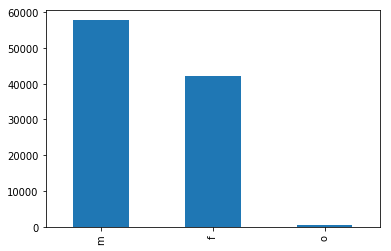

In [20]:
gender_data.gender.value_counts().plot(kind='bar')

Since this's a binary classification problem, we only consider gender of male or female.  

Let's clean the data set to retain happy moments whose gender is either male or female.

In [21]:
gender_bin_data = gender_data[(gender_data['gender'] == 'm') | (gender_data['gender'] == 'f')]

print("Happy moments written by male/female: {}".format(gender_bin_data['cleaned_hm'].size))

Happy moments written by male/female: 99759


To prepare the data for classification task, we need to convert the representation of male and female into numbers.

In [29]:
gender_bin_data = gender_bin_data.assign(gender_bin=(np.where(gender_bin_data['gender']=='m', 1, 0)))

gender_bin_data.head()

,cleaned_hm,gender,gender_bin
0,I went on a successful date with someone I fel...,m,1
1,I played a new game that was fun and got to en...,m,1
2,I listened to some music and heard an entire a...,m,1
3,Went to see a movie with my friend,m,1
4,"Played guitar, learning a song on it",m,1


We use the first 70% happy moments as the training data, with the rest 30% as test data.

In [30]:
hm_size = gender_bin_data['cleaned_hm'].size
num_train_hm = int(0.7 * gender_bin_data['cleaned_hm'].size)

train_hm = gender_bin_data.iloc[0:num_train_hm]
test_hm = gender_bin_data.iloc[num_train_hm:hm_size]
test_hm = test_hm.reset_index(drop=True)

test_hm.head()

,cleaned_hm,gender,gender_bin
0,"I started to walk more around the office, meet...",f,0
1,I bought my mom a bonsai tree for Mother's Day...,f,0
2,I was able to plan out the next two months as ...,f,0
3,I had dinner with coworkers who were leaving e...,f,0
4,I bought presents for my nieces for their home...,f,0


We further clean up the texts, to remove numbers and punctuation.

In [31]:
def clean_up_texts(hm_data):
    prepro_hm = []
    stops = set(stopwords.words("english"))
    for i in range(0, hm_data['cleaned_hm'].size):
        # Remove non-english words, including punctuations and numbers
        letters = re.sub("[^a-zA-Z]", " ", hm_data.iloc[i]['cleaned_hm'])

        # Convert all words to lower case
        lower_words = letters.lower()

        # Tokenize the sentences
        tokens = lower_words.split()

        # Reconstruct the processed tokens into a string
        prepro_string = " ".join(tokens)

        prepro_hm.append(prepro_string)
        
    return prepro_hm
    
prepro_train = clean_up_texts(train_hm)
prepro_test = clean_up_texts(test_hm)
print("Preprocessing done! \n")

Preprocessing done! 



Let's take a peek at the cleaned data:

In [32]:
prepro_train[:10]

['i went on a successful date with someone i felt sympathy and connection with',
 'i played a new game that was fun and got to enjoy the mechanics of it',
 'i listened to some music and heard an entire album i hadn t heard more than once before',
 'went to see a movie with my friend',
 'played guitar learning a song on it',
 'talked to my romantic prospect',
 'i played a game for about half an hour',
 'i discovered another album i hadn t heard by a band i recently got into',
 'i talked to the girl i m dating about some interesting topics',
 'i was happy when my son got marks in his examination']

### 3.2 Feature selection

The next step is to select proper features for training and testing.

Here I start with the simpliest model: *bag-of-words model*.  

bag-of-words model tries to create a dictionary based on the input strings.  
With the dictionary, each sentence can then be modeled as a vector representing the frequency of each words.

I use scikit-learn here to build features for bag-of-words model.

In [33]:
vectorizer = CountVectorizer()
features_train_hm = vectorizer.fit_transform(prepro_train)
train_array_hm = features_train_hm.toarray()

print("Dimension of the training data: {}".format(train_array_hm.shape))

Dimension of the training data: (69831, 20737)


A quick look at the features we use:

In [34]:
vocab = vectorizer.get_feature_names()

vocab[:20]

['aa',
 'aaa',
 'aadat',
 'aadhaar',
 'aadhar',
 'aagra',
 'aakshayatriya',
 'aas',
 'aashwin',
 'ab',
 'aback',
 'abacus',
 'abandon',
 'abandoned',
 'abasket',
 'abating',
 'abbott',
 'abby',
 'abc',
 'abcs']

Now we can train a logistic regression model with the extracted features.  

### 3.3 Training of the logistic regression classifier

Let's train the logistic regression model:

In [35]:
from sklearn.linear_model import LogisticRegression

logi_model = LogisticRegression()
logi_model.fit(train_array_hm, train_hm['gender_bin'])

logi_model.score(train_array_hm, train_hm['gender_bin'])

0.76023542552734458

The training accuracy is 76%, a reasonable result.

We can see which words are most influential by looking at the coefficients of the logistic model.

In [36]:
feature_names = vocab
coefficients = logi_model.coef_.tolist()[0]
weight_df = pd.DataFrame({'Word': feature_names,
                          'Coeff': coefficients})
weight_df = weight_df.sort_values(['Coeff', 'Word'], ascending=[0, 1])
weight_df.head(n=10)

,Coeff,Word
20291,3.178912,wife
7642,2.850127,girlfriend
7593,2.001084,gf
17551,1.917807,stone
16855,1.832706,smoking
14631,1.776490,reaches
16091,1.755520,seattle
1661,1.747573,begging
3441,1.674358,climbs
20172,1.660420,wend


These are the words with the biggest positive coefficients.  

In other words, these are the words in the dataset that strongly suggest male.

Well, I can understand that mentioning of "wife", "gf" or "smoking" suggests a male author.  

But why "seattle" and "stone"? This is definitely worth more investigation.

Let's also take a look at the least influential words:

In [37]:
weight_df.tail(n=10)

,Coeff,Word
7857,-1.957479,grandkids
11991,-1.979667,nails
8774,-2.092423,hubby
1292,-2.099750,babysit
1953,-2.118816,blissful
10043,-2.153748,knitting
10932,-2.278422,makeup
11846,-2.541355,mth
2195,-2.633498,boyfriend
8842,-3.364651,husband


These are the words that tend to make classifier predict 0, which means female.

Most of the words make sense to me, but again, the appearance of "mth" is kind of surprising.

### 3.4 Evaluation of the classifier

To evaluate the performance of the classifier, let's use the trained model to make prediction on the test data.

In [38]:
features_test_hm = vectorizer.transform(prepro_test)
test_array_hm = features_test_hm.toarray()

print("Dimension of the test data: {}".format(test_array_hm.shape))

Dimension of the test data: (29928, 20737)


In [39]:
predictions = logi_model.predict(test_array_hm)

In [40]:
from sklearn import metrics

print(metrics.accuracy_score(test_hm['gender_bin'], predictions))

0.639468056669


We have 64% precision on the test data.

For anyone who wants to learn more about bag-of-words model, I recommend this [tutorial](https://www.kaggle.com/c/word2vec-nlp-tutorial#part-1-for-beginners-bag-of-words).

# 4. Conclusion

This notebook is just a preliminary exploration of the dataset.  I'm sure there's much more to dig there.

Some of the future directions I can think of now is:
- Extraction of locations that make people feel happy.
- More sophisticated features with logistic regression model (e.g., ngram model).
- More sophisticated models (e.g., a neural network).
